In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
import os
import warnings

warnings.filterwarnings('ignore')

In [68]:
def load_and_combine_data():
    df1 = pd.read_csv('airforce_channels_anomalous.csv')
    df2 = pd.read_csv('random_news_channels.csv')
    combined_df = pd.concat([df1, df2], axis=0, ignore_index=True)
    return combined_df

In [69]:
def preprocess_data(df):
    channel_ids = df['channel_id']
    df = df.drop(columns=['channel_id']).fillna(0)
    return df, channel_ids

In [70]:
#Scale Data
def scale_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

In [71]:
#PCA for Dimensionality Reduction
def perform_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    return pca_data, pca

In [72]:
def find_optimal_k(data):
    silhouette_scores = []
    print("Evaluating K-Means clustering silhouette scores:")
    for k in range(2, 6):  # Change the range as needed
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
        print(f"Number of Clusters: {k}, Silhouette Score: {score:.4f}")
    
    optimal_k = 2 + np.argmax(silhouette_scores)
    return optimal_k, silhouette_scores

In [73]:
#Perform K-Means Clustering
def perform_kmeans(data, n_clusters):
    """
    Perform K-Means clustering.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels, kmeans

In [74]:
#Save Cluster Data
def save_cluster_data(df, labels, channel_ids):
    """
    Save clusters to CSV files and validate counts.
    """
    df['channel_id'] = channel_ids
    df['cluster_id'] = labels
    output_dir = 'clusters_output'
    os.makedirs(output_dir, exist_ok=True)
    
    for cluster_id in np.unique(labels):
        cluster_df = df[df['cluster_id'] == cluster_id]
        cluster_df.to_csv(f"{output_dir}/cluster_{cluster_id}.csv", index=False)
        print(f"Cluster {cluster_id}: {len(cluster_df)} elements saved.")

In [75]:
#Plot K-Means Clusters
def plot_clusters(data, labels, title="Clusters"):
    """
    Plot clusters in 2D space.
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette="viridis", s=100)
    plt.title(title, fontsize=16)
    plt.xlabel("PC1", fontsize=16)
    plt.ylabel("PC2", fontsize=16)
    plt.legend(title="Cluster", fontsize=12)
    plt.show()

In [76]:
#Plot Hierarchical Clusters
def perform_hierarchical_clustering(data, max_clusters=10):
    linkage_matrix = linkage(data, method="ward")
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
    plt.xlabel("Channel Index", fontsize=16)
    plt.ylabel("Distance", fontsize=16)
    plt.show()
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
        #print(f"Number of Clusters: {k}, Silhouette Score: {score:.4f}")
    optimal_k = 2 + np.argmax(silhouette_scores)
    return optimal_k, silhouette_scores

In [77]:
# Step 10: Validate Cophenetic Coefficient
def calculate_cophenetic_coefficient(data):
    linkage_matrix = linkage(data, method="ward")
    c, _ = cophenet(linkage_matrix, pdist(data))
    return c


Performing K-Means Clustering...
Evaluating K-Means clustering silhouette scores:
Number of Clusters: 2, Silhouette Score: 0.6118
Number of Clusters: 3, Silhouette Score: 0.4675
Number of Clusters: 4, Silhouette Score: 0.4773
Number of Clusters: 5, Silhouette Score: 0.4650
Optimal K for K-Means: 2

Cluster 0: 7 elements saved.
Cluster 1: 40 elements saved.


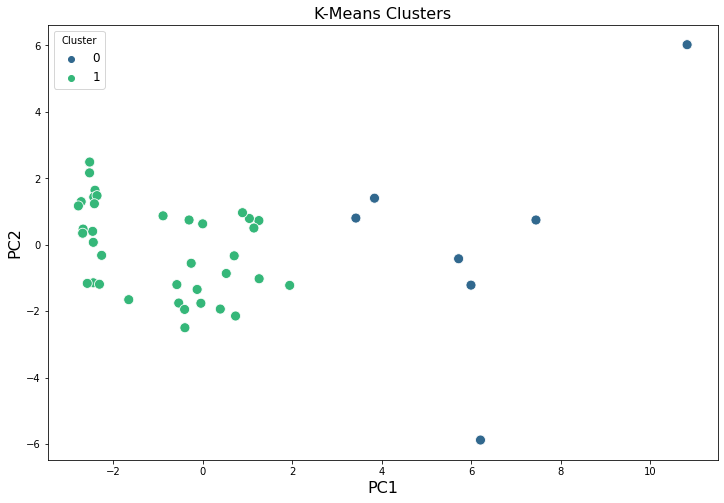


Performing Hierarchical Clustering...


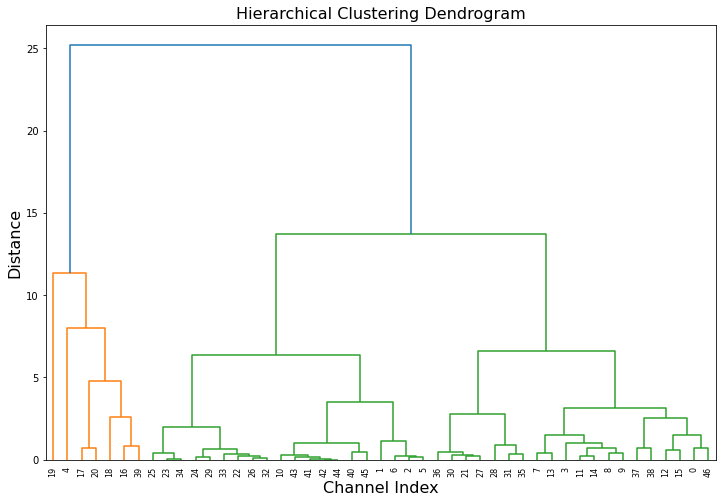

Cophenetic Coefficient: 0.7974


In [78]:
df = load_and_combine_data()
df, channel_ids = preprocess_data(df)
scaled_data, scaler = scale_data(df)

# Perform PCA
pca_data, pca = perform_pca(scaled_data)

# K-Means Clustering
print("\nPerforming K-Means Clustering...")
optimal_k, silhouette_scores = find_optimal_k(pca_data)
print(f"Optimal K for K-Means: {optimal_k}\n")
labels, kmeans = perform_kmeans(pca_data, optimal_k)

# Save and plot clusters
save_cluster_data(df, labels, channel_ids)
plot_clusters(pca_data, labels, title="K-Means Clusters")

# Hierarchical Clustering
print("\nPerforming Hierarchical Clustering...")
optimal_h_k, h_silhouette_scores = perform_hierarchical_clustering(pca_data)
coph_coef = calculate_cophenetic_coefficient(pca_data)
print(f"Cophenetic Coefficient: {coph_coef:.4f}")